In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, f1_score, recall_score, roc_curve, auc, label_binarize, roc_auc_score
from sklearn.preprocessing import LabelEncoder

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from collections import defaultdict, Counter

import re
from textblob import Word
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO
from autocorrect import Speller

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import nltk
from nltk.tokenize import word_tokenize
from transformers import BertTokenizer, BertModel

# ---------------------------------------------
# run the following only once to download the nltk data
# ---------------------------------------------
# import nltk
# nltk.download('stopwords', quiet=True)
# nltk.download('wordnet', quiet=True)
# nltk.download('punkt_tab', quiet=True)

In [15]:
# ---------------------------------------------
# preprocess text function
# ---------------------------------------------
def preprocess_text(text):
    abbreviation_dict = {
        "u": "you", "bked": "booked", "thx": "thanks", "plz": "please",
        "sfo": "san francisco airport", "lax": "los angeles airport",
        "nyc": "new york city", "bos": "boston", "las": "las vegas",
        "dal": "dallas", "dca": "washington, d.c.", "lg": "likely good"
    }
    english_contractions_dict = {
        "ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have",
        "could've": "could have", "couldn't": "could not", "couldn't've": "could not have",
        "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
        "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will",
        "he's": "he is", "how'd": "how did", "how'll": "how will", "how's": "how is",
        "i'd": "i would", "i'll": "i will", "i'm": "i am", "i've": "i have", "isn't": "is not",
        "it'd": "it would", "it'll": "it will", "it's": "it is", "let's": "let us",
        "ma'am": "madam", "might've": "might have", "mightn't": "might not", "must've": "must have",
        "mustn't": "must not", "needn't": "need not", "shan't": "shall not", "she'd": "she would",
        "she'll": "she will", "she's": "she is", "should've": "should have", "shouldn't": "should not",
        "that'd": "that would", "that's": "that is", "there's": "there is", "they'd": "they would",
        "they'll": "they will", "they're": "they are", "they've": "they have", "wasn't": "was not",
        "we'd": "we would", "we're": "we are", "we've": "we have", "weren't": "were not",
        "what'll": "what will", "what're": "what are", "what's": "what is", "what've": "what have",
        "where's": "where is", "who's": "who is", "who've": "who have", "won't": "will not",
        "would've": "would have", "wouldn't": "would not", "you'd": "you would", "you'll": "you will",
        "you're": "you are", "you've": "you have"
    }
    spell = Speller(lang='en')
    english_stopwords = stopwords.words("english")

    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\S+', '', text)

    words = text.split()
    new_words = [abbreviation_dict.get(word, word) for word in words]
    text = " ".join(new_words)

    words = text.split()
    new_words = [english_contractions_dict.get(word, word) for word in words]
    text = " ".join(new_words)

    for emot in UNICODE_EMOJI:
        if emot in text:
            text = text.replace(
                emot,
                " " + UNICODE_EMOJI[emot].replace(":", "").replace(",", "").replace("_", " ") + " "
            ).lower()
    for emo in EMOTICONS_EMO:
        if emo in text:
            text = text.replace(
                emo,
                " " + EMOTICONS_EMO[emo].replace(":", "").replace(",", "").replace("_", " ") + " "
            ).lower()

    text = re.sub(r'[^\w\s]', '', text)
    text = " ".join(x for x in text.split() if x.lower() not in english_stopwords)
    text = ' '.join(spell(word) for word in text.split())
    text = " ".join(Word(word).lemmatize() for word in text.split())
    tokens = word_tokenize(text)
    
    return tokens


# ---------------------------------------------
# evaluate model function
# ---------------------------------------------
def evaluate_model(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    train_precision = precision_score(y_train, y_train_pred, average='weighted')
    train_recall = recall_score(y_train, y_train_pred, average='weighted')
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')

    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    metrics = {
        'Training': {
            'Accuracy': train_accuracy * 100,
            'Precision': train_precision * 100,
            'Recall': train_recall * 100,
            'F1-score': train_f1 * 100
        },
        'Testing': {
            'Accuracy': test_accuracy * 100,
            'Precision': test_precision * 100,
            'Recall': test_recall * 100,
            'F1-score': test_f1 * 100
        }
    }    
    
    print("\nMetrics Differences (Training - Testing):")
    print(f"Accuracy Diff: {(train_accuracy - test_accuracy)*100:.2f}%")
    print(f"Precision Diff: {(train_precision - test_precision)*100:.2f}%")
    print(f"Recall Diff: {(train_recall - test_recall)*100:.2f}%")
    print(f"F1-Score Diff: {(train_f1 - test_f1)*100:.2f}%")
    
    print(f"\nTraining Metrics:")
    print(f"Accuracy: {train_accuracy*100:.2f}%")
    print(f"Precision: {train_precision*100:.2f}%") 
    print(f"Recall: {train_recall*100:.2f}%")
    print(f"F1-Score: {train_f1*100:.2f}%")
    
    print(f"\nTesting Metrics:")
    print(f"Accuracy: {test_accuracy*100:.2f}%")
    print(f"Precision: {test_precision*100:.2f}%")
    print(f"Recall: {test_recall*100:.2f}%") 
    print(f"F1-Score: {test_f1*100:.2f}%")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    metrics_train = list(metrics['Training'].values())
    metrics_labels = list(metrics['Training'].keys())
    ax1.bar(metrics_labels, metrics_train, color=['blue', 'green', 'red', 'purple'])
    ax1.set_title('Training Metrics')
    ax1.set_ylim(0, 100)
    ax1.set_ylabel('Score (%)')
    ax1.grid(True, alpha=0.3)
    for i, v in enumerate(metrics_train):
        ax1.text(i, v + 1, f'{v:.2f}%', ha='center')
        
    metrics_test = list(metrics['Testing'].values())
    ax2.bar(metrics_labels, metrics_test, color=['blue', 'green', 'red', 'purple'])
    ax2.set_title('Testing Metrics')
    ax2.set_ylim(0, 100)
    ax2.set_ylabel('Score (%)')
    ax2.grid(True, alpha=0.3)
    for i, v in enumerate(metrics_test):
        ax2.text(i, v + 1, f'{v:.2f}%', ha='center')        
        
    plt.tight_layout()
    plt.show()
    
    cm = confusion_matrix(y_test, y_test_pred, labels=['positive', 'negative', 'neutral'])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['positive', 'negative', 'neutral'], yticklabels=['positive', 'negative', 'neutral'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(X_test)
    else:
        y_score = model.decision_function(X_test)
        y_score = np.exp(y_score) / np.sum(np.exp(y_score), axis=1, keepdims=True)
    
    classes = ['positive', 'negative', 'neutral']
    y_test_bin = pd.get_dummies(y_test).values
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(6, 4))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(len(classes)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve for {classes[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Multi-Class Sentiment Analysis')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# ---------------------------------------------
# loading dataset
# ---------------------------------------------

# df = pd.read_csv("../../../data/clean_Tweets.csv")
df = pd.read_csv("https://raw.githubusercontent.com/ThisIsMrIsmail/twitter-us-airline-sentiment-analysis/refs/heads/main/data/clean_Tweets.csv")

X = df["text"]
y = df["airline_sentiment"]

### Feature Extraction Techniques Overview

__GloVe PyTorch__:  
Uses pre-trained word embeddings to represent words as dense vectors.  
Cons: Requires large memory for embedding matrix; ignores word order/context.

__GloVe TensorFlow__:  
Similar to PyTorch, uses GloVe vectors in Keras models.  
Cons: Same as above; setup can be complex.

__TF-IDF Vectorizer__:  
Converts text to features based on word frequency and importance.  
Cons: Ignores word order and context; high dimensionality.

__Word2Vec__:  
Learns word vectors from data, capturing semantic similarity.  
Cons: Needs large corpus; averages lose sentence structure.

__BERT Embeddings__:  
Generates contextualized embeddings for each word using transformers.  
Cons: Computationally expensive; slow inference.

__N-gram Features__:  
Represents text by counts of word sequences (bigrams, trigrams, etc.).  
Cons: High dimensionality; sparse features; ignores context.

__N-gram with TF-IDF__ [best performance]:  
Combines n-grams and TF-IDF to capture phrases and importance.  
Cons: Very high dimensionality.


In [ ]:
# -------------------------------------------------
# GloVe PyTorch
# -------------------------------------------------
# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y)
# max_words = 10000
# max_len = 50
# tokenizer = word_tokenize
# def build_vocab(texts, max_words):
#     word_freq = {}
#     for text in texts:
#         for word in tokenizer(text):
#             word_freq[word] = word_freq.get(word, 0) + 1
#     vocab = {word: idx + 1 for idx, (word, _) in enumerate(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:max_words-1])}
#     vocab["<OOV>"] = 0
#     return vocab
# vocab = build_vocab(X, max_words)
# X_sequences = [[vocab.get(word, vocab["<OOV>"]) for word in tokenizer(text)][:max_len] for text in X]
# X_padded = [seq + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in X_sequences]
# X_padded = np.array(X_padded)
# embedding_dim = 100
# embeddings_index = {}
# with open("../../../data/glove.6B.100d.txt", encoding="utf-8") as f:
#     for line in f:
#         values = line.split()
#         word = values[0]
#         coefs = np.asarray(values[1:], dtype="float32")
#         embeddings_index[word] = coefs
# embedding_matrix = np.zeros((max_words, embedding_dim))
# for word, idx in vocab.items():
#     if idx < max_words:
#         embedding_vector = embeddings_index.get(word)
#         if embedding_vector is not None:
#             embedding_matrix[idx] = embedding_vector
# embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)


# -------------------------------------------------
# GloVe TensorFlow
# -------------------------------------------------
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from sklearn.preprocessing import LabelEncoder
# data = pd.read_csv("clean_Tweets.csv")
# X = data["text"]
# y = data["airline_sentiment"]
# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y)
# max_words = 10000
# max_len = 50
# tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
# tokenizer.fit_on_texts(X)
# X_sequences = tokenizer.texts_to_sequences(X)
# X_padded = tokenizer.texts_to_sequences(X)
# X_padded = pad_sequences(X_sequences, maxlen=max_len, padding="post", truncating="post")
# embedding_dim = 100
# embeddings_index = {}
# with open("glove.6B.100d.txt", encoding="utf-8") as f:
#     for line in f:
#         values = line.split()
#         word = values[0]
#         coefs = np.asarray(values[1:], dtype="float32")
#         embeddings_index[word] = coefs
# embedding_matrix = np.zeros((max_words, embedding_dim))
# for word, i in tokenizer.word_index.items():
#     if i < max_words:
#         embedding_vector = embeddings_index.get(word)
#         if embedding_vector is not None:
#             embedding_matrix[i] = embedding_vector


# -------------------------------------------------
# TF-IDF Vectorizer
# -------------------------------------------------
# vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
# X_vectorized = vectorizer.fit_transform(X)


# -------------------------------------------------
# Word2Vec
# -------------------------------------------------
# w2v_model = Word2Vec(sentences=[text.split() for text in X], vector_size=100, window=5, min_count=1, workers=4)
# def text_to_vec(text, model):
#     words = text.split()
#     word_vecs = [model.wv[word] for word in words if word in model.wv]
#     if len(word_vecs) == 0:
#         return np.zeros(model.vector_size)
#     return np.mean(word_vecs, axis=0)
# X_vectorized = np.array([text_to_vec(text, w2v_model) for text in X])


# -------------------------------------------------
# BERT Embeddings
# -------------------------------------------------
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased')
# def text_to_bert_vec(text, tokenizer, model):
#     inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
#     with torch.no_grad():
#         outputs = model(**inputs)
#     return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
# X_vectorized = np.array([text_to_bert_vec(text, tokenizer, model) for text in X])
# pd.DataFrame(X_vectorized).to_csv('../../../vector_data/X_bert_embeddings.csv', index=False)


# -------------------------------------------------
# N-gram Features
# -------------------------------------------------
# bigram_vectorizer = CountVectorizer(
#     ngram_range=(2,2),
#     max_features=20000,
#     stop_words='english'
# )
# trigram_vectorizer = CountVectorizer(
#     ngram_range=(3,3),
#     max_features=20000,
#     stop_words='english'
# )
# X_bigram = bigram_vectorizer.fit_transform(X)
# X_trigram = trigram_vectorizer.fit_transform(X)
# X_vectorized = np.hstack((X_bigram.toarray(), X_trigram.toarray()))
# pd.DataFrame(X_vectorized).to_csv('../../../vector_data/X_ngram_features.csv', index=False)

In [ ]:
# -------------------------------------------------
# N-grams with TF-IDF
# -------------------------------------------------
"""
Using n-grams with TF-IDF captures more contextual information
and word combinations, which can improve the performance of
text classification models by considering not just single words
but also common phrases and word pairs.
"""

class n_grams_tf_idf_vectorization:
    def __init__(self, max_features=5000, token_pattern=r"(?u)\b\w+\b", ngram_range=(1, 3)):
        self.max_features = max_features
        self.token_pattern = re.compile(token_pattern)
        self.ngram_range = ngram_range
        self.vocabulary_ = {}
        self.idf_ = {}

    def _tokenize(self, text):
        return self.token_pattern.findall(text.lower())

    def _generate_ngrams(self, tokens):
        ngram_tokens = []
        min_n, max_n = self.ngram_range
        for n in range(min_n, max_n + 1):
            ngram_tokens.extend([' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)])
        return ngram_tokens

    def fit(self, raw_documents):
        df = defaultdict(int)
        doc_count = len(raw_documents)

        for doc in raw_documents:
            tokens = self._tokenize(doc)
            ngrams = self._generate_ngrams(tokens)
            unique_terms = set(ngrams)
            for term in unique_terms:
                df[term] += 1

        # Calculate IDF and build vocabulary
        sorted_terms = sorted(df.items(), key=lambda x: -x[1])[:self.max_features]
        self.vocabulary_ = {term: idx for idx, (term, _) in enumerate(sorted_terms)}
        self.idf_ = {
            term: np.log((1 + doc_count) / (1 + df[term])) + 1.0
            for term in self.vocabulary_
        }

        return self

    def transform(self, raw_documents):
        n_docs = len(raw_documents)
        n_features = len(self.vocabulary_)
        X = np.zeros((n_docs, n_features), dtype=np.float32)

        for doc_idx, doc in enumerate(raw_documents):
            tokens = self._tokenize(doc)
            ngrams = self._generate_ngrams(tokens)
            tf = Counter(ngrams)

            for term, count in tf.items():
                if term in self.vocabulary_:
                    tf_val = count / len(ngrams)
                    idf_val = self.idf_[term]
                    tfidf = tf_val * idf_val
                    X[doc_idx, self.vocabulary_[term]] = tfidf

        return X

    def fit_transform(self, raw_documents):
        self.fit(raw_documents)
        return self.transform(raw_documents)


vectorizer = n_grams_tf_idf_vectorization(max_features=20000, ngram_range=(1, 2))
X_vectorized = vectorizer.fit_transform(X)

print("Vocabulary:", vectorizer.vocabulary_)
print("TF-IDF Matrix:\n", X_vectorized)

Vocabulary: {'flight': 0, 'get': 1, 'thanks': 2, 'hour': 3, 'cancelled': 4, 'service': 5, 'customer': 6, 'time': 7, 'help': 8, 'would': 9, 'lighted': 10, 'u': 11, 'cancelled lighted': 12, 'bag': 13, 'plane': 14, 'hold': 15, 'need': 16, '2': 17, 'amp': 18, 'face': 19, 'can': 20, 'please': 21, 'thank': 22, 'customer service': 23, 'still': 24, 'not': 25, 'one': 26, 'can not': 27, 'airline': 28, 'day': 29, 'call': 30, 'delayed': 31, 'back': 32, 'airport': 33, 'gate': 34, 'got': 35, 'phone': 36, 'seat': 37, 'delay': 38, 'like': 39, 'today': 40, 'guy': 41, 'late': 42, 'agent': 43, 'late flight': 44, 'fly': 45, 'ticket': 46, 'know': 47, 'make': 48, 'happy': 49, 'waiting': 50, 'trying': 51, 'way': 52, 'change': 53, 'could': 54, 'go': 55, 'minute': 56, 'going': 57, 'great': 58, 'wait': 59, 'flying': 60, 'never': 61, '3': 62, 'tomorrow': 63, 'problem': 64, 'new': 65, 'last': 66, 'good': 67, 'weather': 68, 'really': 69, 'take': 70, 'min': 71, 'even': 72, 'home': 73, 'hr': 74, 'people': 75, '4': 7

In [ ]:
df["text"].describe()

In [ ]:
# -------------------------------------------------
# handling data imbalance
# -------------------------------------------------
"""
I tried the following techniques to handle  the imbalance in the dataset:
 - SMOTE (generating samples)
 - Random Under Sampling (deleting records from majority classes)
 - Random Over Sampling (adding records to  minority classes) [best performance]
"""

# sampler = SMOTE(random_state=42)
# sampler = RandomUnderSampler(random_state=42)

sampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = sampler.fit_resample(X_vectorized, y)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=42)

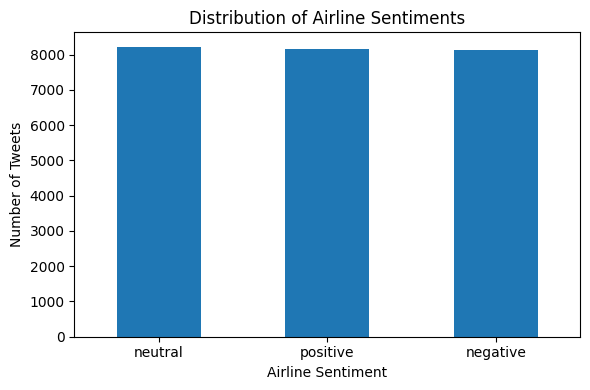

In [ ]:
# ---------------------------------------------
# getting classes distribution
# ---------------------------------------------
sentiment_counts = pd.Series(y_train).value_counts()

plt.figure(figsize=(6, 4))
sentiment_counts.plot(kind='bar')
plt.xlabel('Airline Sentiment')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Airline Sentiments')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 1. Machine Learning Models
1. __Logistic Regression__
2. __Naive Bayes__
3. __Random Forest with Grid Seach__
4. __Support Vector Machine__

### 1. Logistic Regression


Metrics Differences (Training - Testing):
Accuracy Diff: 5.60%
Precision Diff: 5.58%
Recall Diff: 5.60%
F1-Score Diff: 5.65%

Training Metrics:
Accuracy: 96.13%
Precision: 96.13%
Recall: 96.13%
F1-Score: 96.13%

Testing Metrics:
Accuracy: 90.53%
Precision: 90.55%
Recall: 90.53%
F1-Score: 90.48%


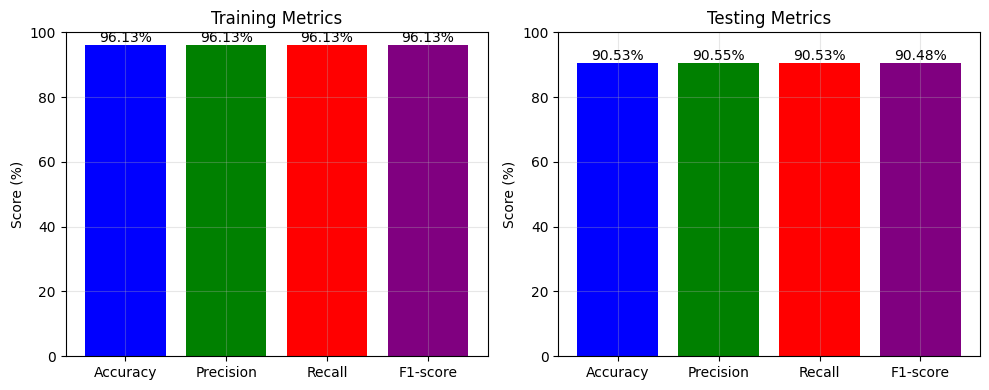

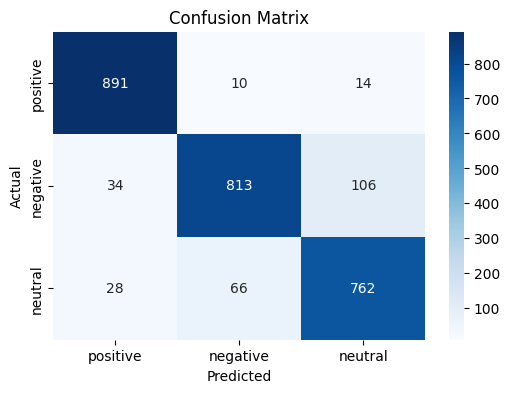

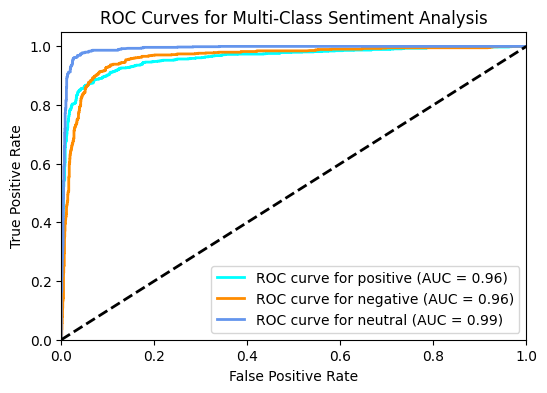

In [22]:
logistic_regression_classifier = LogisticRegression(random_state=42, max_iter=2000)
logistic_regression_classifier.fit(X_train, y_train)
evaluate_model(logistic_regression_classifier, X_train, X_test, y_train, y_test)

### 2. Naive Bayes


Metrics Differences (Training - Testing):
Accuracy Diff: 6.16%
Precision Diff: 6.24%
Recall Diff: 6.16%
F1-Score Diff: 6.22%

Training Metrics:
Accuracy: 90.08%
Precision: 90.08%
Recall: 90.08%
F1-Score: 90.06%

Testing Metrics:
Accuracy: 83.92%
Precision: 83.84%
Recall: 83.92%
F1-Score: 83.83%


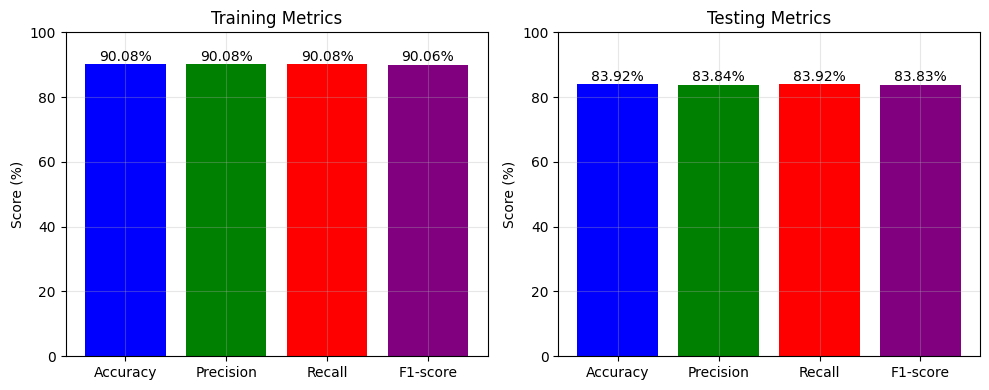

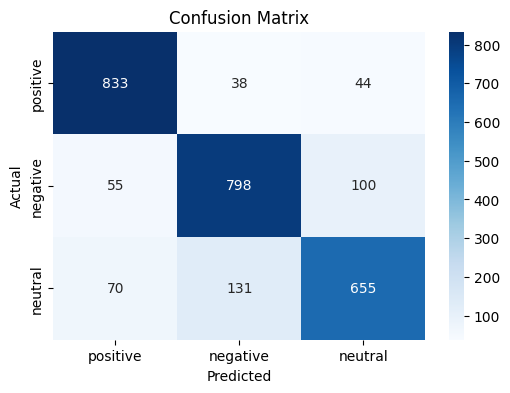

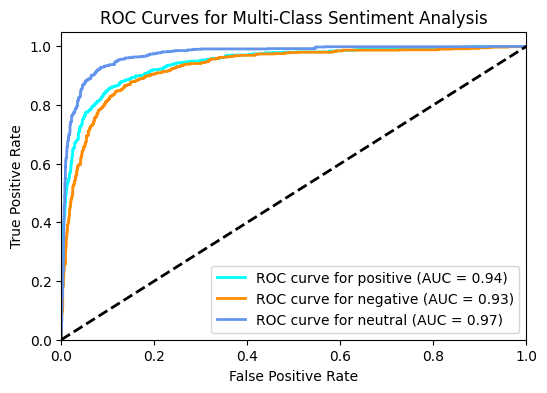

In [23]:
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train, y_train)
evaluate_model(naive_bayes_classifier, X_train, X_test, y_train, y_test)

### 3. Random Forest with Grid Seach

In [24]:
rf_param_grid = { 'n_estimators': [100, 200], 'max_depth': [10, 20, None] }
rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, rf_param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_
print("\nbest parameters:", rf_grid.best_params_)
evaluate_model(best_rf, X_train, X_test, y_train, y_test)

KeyboardInterrupt: 

### 4. Support Vector Machine

In [ ]:
support_vector_machine_classifier = SVC(kernel='linear', random_state=42)
support_vector_machine_classifier.fit(X_train, y_train)
evaluate_model(support_vector_machine_classifier, X_train, X_test, y_train, y_test)

# 2. Deep Learning Model
### [RNN with GRU] Recurrent Neural Network with Gated Recurrent Unit

In [ ]:
# reshaping vectorized matrix for GRU (simulate sequence)
seq_length = 50
feature_dim = X_resampled.shape[1] // seq_length
X_reshaped = X_resampled.reshape(-1, seq_length, feature_dim)

# converting rashaped matrix to PyTorch tensors
X_reshaped = torch.tensor(X_reshaped, dtype=torch.float32)
y_resampled = torch.tensor(y_resampled, dtype=torch.long)

class TweetDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = TweetDataset(X_reshaped, y_resampled)
batch_size = 32

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(GRU, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, output_dim)

    def forward(self, x):
        _, hidden = self.gru(x)
        hidden = hidden.squeeze(0)
        out = self.fc1(hidden)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [ ]:
# model initialization
input_dim = feature_dim
hidden_dim = 128
output_dim = 3
model = GRU(input_dim, hidden_dim, output_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# training loop
num_epochs = 150
best_test_loss = float("inf")
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [ ]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += y_batch.size(0)
        train_correct += (predicted == y_batch).sum().item()
    train_loss /= len(train_loader)
    train_accuracy = train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            test_total += y_batch.size(0)
            test_correct += (predicted == y_batch).sum().item()
        test_loss /= len(test_loader)
        test_accuracy = test_correct / test_total
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_accuracy*100:.2f}%, Test Acc: {test_accuracy*100:.2f}%")

    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), "best_gru_model.pt")

In [ ]:
# model evaluation
model.load_state_dict(torch.load("best_gru_model.pt"))
model.eval()

label_encoder = LabelEncoder()

def evaluate_model(loader, model, device, label_encoder):
    y_true = []
    y_pred = []
    y_scores = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            probabilities = torch.softmax(outputs, dim=1)  # softmax for ROC
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(probabilities.cpu().numpy())
    report = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    return y_true, y_pred, y_scores, report, cm

# training evaluation
train_true, train_pred, train_scores, train_report, _ = evaluate_model(train_loader, model, device, label_encoder)
train_accuracy = train_report['accuracy']
train_precision = train_report['macro avg']['precision']
train_recall = train_report['macro avg']['recall']
train_f1 = train_report['macro avg']['f1-score']

# testing evaluation
test_true, test_pred, test_scores, test_report, test_cm = evaluate_model(test_loader, model, device, label_encoder)
test_accuracy = test_report['accuracy']
test_precision = test_report['macro avg']['precision']
test_recall = test_report['macro avg']['recall']
test_f1 = test_report['macro avg']['f1-score']

print("\nTraining Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-Score: {train_f1:.4f}")
print("\nTraining Classification Report:")
print(classification_report(train_true, train_pred, target_names=label_encoder.classes_, zero_division=0))

print("\nTesting Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print("\nTesting Classification Report:")
print(classification_report(test_true, test_pred, target_names=label_encoder.classes_, zero_division=0))

# binarize labels for multi-class ROC
# ['negative', 'neutral', 'positive']
classes = label_encoder.classes_
y_train_bin = label_binarize(train_true, classes=[0, 1, 2])
y_test_bin = label_binarize(test_true, classes=[0, 1, 2])
train_scores = np.array(train_scores)
test_scores = np.array(test_scores)

train_fpr = {}
train_tpr = {}
train_roc_auc = {}
test_fpr = {}
test_tpr = {}
test_roc_auc = {}

for i, class_name in enumerate(classes):
    # training ROC
    train_fpr[i], train_tpr[i], _ = roc_curve(y_train_bin[:, i], train_scores[:, i])
    train_roc_auc[i] = roc_auc_score(y_train_bin[:, i], train_scores[:, i])
    # testing ROC
    test_fpr[i], test_tpr[i], _ = roc_curve(y_test_bin[:, i], test_scores[:, i])
    test_roc_auc[i] = roc_auc_score(y_test_bin[:, i], test_scores[:, i])

all_fpr = np.unique(np.concatenate([train_fpr[i] for i in range(len(classes))] + [test_fpr[i] for i in range(len(classes))]))
train_tpr_macro = np.zeros_like(all_fpr)
test_tpr_macro = np.zeros_like(all_fpr)
for i in range(len(classes)):
    train_tpr_macro += np.interp(all_fpr, train_fpr[i], train_tpr[i])
    test_tpr_macro += np.interp(all_fpr, test_fpr[i], test_tpr[i])
train_tpr_macro /= len(classes)
test_tpr_macro /= len(classes)
train_roc_auc_macro = roc_auc_score(y_train_bin, train_scores, average='macro', multi_class='ovr')
test_roc_auc_macro = roc_auc_score(y_test_bin, test_scores, average='macro', multi_class='ovr')

# displaying ROC curves
plt.figure(figsize=(6, 4))
colors = ['blue', 'green', 'red']
for i, class_name in enumerate(classes):
    plt.plot(train_fpr[i], train_tpr[i], color=colors[i], linestyle='--', label=f'Train {class_name} (AUC = {train_roc_auc[i]:.2f})')
    plt.plot(test_fpr[i], test_tpr[i], color=colors[i], linestyle='-', label=f'Val {class_name} (AUC = {test_roc_auc[i]:.2f})')
plt.plot(all_fpr, train_tpr_macro, color='black', linestyle='--', label=f'Train Macro-Avg (AUC = {train_roc_auc_macro:.2f})')
plt.plot(all_fpr, test_tpr_macro, color='black', linestyle='-', label=f'Val Macro-Avg (AUC = {test_roc_auc_macro:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Training and Testing Sets')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Testing Confusion Matrix")
plt.show()

# training history plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Val Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

## Making Predictions

In [ ]:
text = "I'm so happy with the service, I will definitely fly with them again!"
text = "I'm am going to have my lunch now"
text = "This flight was terrible, I will never fly with them again!"

text_vectorized = vectorizer.transform([text])

# machine learning predictions
lr_prediction = logistic_regression_classifier.predict(text_vectorized)
nb_prediction = naive_bayes_classifier.predict(text_vectorized)
rf_prediction = rf_grid.best_estimator_.predict(text_vectorized)
svm_prediction = support_vector_machine_classifier.predict(text_vectorized)

# deep learning prediction
text_reshaped = text_vectorized.reshape(1, seq_length, feature_dim)
text_tensor = torch.tensor(text_reshaped, dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
    output = model(text_tensor)
    _, predicted = torch.max(output, 1)
predicted_label = label_encoder.inverse_transform([predicted.cpu().numpy()[0]])[0]

# displaying predictions
print(f"\nExample text: {text}")

print(f"Logistic Regression: {lr_prediction[0]}")
print(f"Naive Bayes: {nb_prediction[0]}")
print(f"Support Vector Machine: {svm_prediction[0]}")
print(f"Random Forest: {rf_prediction[0]}")

print(f"\nRNN with GRU: {predicted_label}")